In [1]:
import os
import sys
import glob
import yaml
import pickle
import random

import numpy as np
import pandas as pd
import scipy.stats as stats
from pathlib import Path

from sklearn import model_selection
from sklearn.preprocessing import StandardScaler, LabelEncoder

import wandb
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.utilities.seed import seed_everything

## config

In [2]:
# config
with open('config.yaml') as f:
    config = yaml.safe_load(f)

# globals variable
SEED = config['globals']['seed']
MAX_EPOCHS = config['globals']['max_epochs']
N_SPLITS = config['globals']['n_splits']
USE_FOLDS = config['globals']['use_folds']
DEBUG = config['globals']['debug']
EXP_MESSAGE = config['globals']['exp_message']
NOTES = config['globals']['notes']
MODEL_SAVE = config['globals']['model_save']
ONLY_PRED = config['globals']['only_pred']
PRETRAINED = config['globals']['pretrained']
PRETRAINED_PATH = config['globals']['pretrained_path']
EXP_NAME = str(Path().resolve()).split('/')[-1]

# seed
seed_everything(SEED)

Global seed set to 1996


1996

In [3]:
EXP_NAME

'exp012'

In [4]:
!wandb login 1bb2d0449c11d8b987e25c38b9d8dda176310fb6

wandb: Appending key for api.wandb.ai to your netrc file: /home/user/.netrc


## read data

In [5]:
# waypointを補正したdataset
root_dir = Path('../../input/')
with open(root_dir/'kuto_wifi_dataset_v2/train_all.pkl', 'rb') as f:
  train_df = pickle.load(f)

with open(root_dir/'kuto_wifi_dataset_v2/test_all.pkl', 'rb') as f:
  test_df = pickle.load(f)

sub_df = pd.read_csv(root_dir/'indoor-location-navigation/sample_submission.csv', index_col=0)

In [6]:
train_df.iloc[:, -12:]

,rssi_98,rssi_99,timestamp,x,y,floor,floor_str,path,time_diff,wifi_x,wifi_y,site_id
0,-85,-85,1571625311855,68.064926,241.94000,0,F1,5dad1ca1dc3e2c0006606c3f,1952,66.823935,241.889369,5da958dd46f8266d0737457b
1,-85,-85,1571625311855,68.064926,241.94000,0,F1,5dad1ca1dc3e2c0006606c3f,3900,65.582943,241.838738,5da958dd46f8266d0737457b
2,-83,-83,1571625320099,62.480465,241.71216,0,F1,5dad1ca1dc3e2c0006606c3f,-2385,64.341952,241.788107,5da958dd46f8266d0737457b
3,-83,-83,1571625320099,62.480465,241.71216,0,F1,5dad1ca1dc3e2c0006606c3f,-427,62.480465,241.712160,5da958dd46f8266d0737457b
4,-83,-83,1571625320099,62.480465,241.71216,0,F1,5dad1ca1dc3e2c0006606c3f,1528,62.893219,240.715162,5da958dd46f8266d0737457b
...,...,...,...,...,...,...,...,...,...,...,...,...
258120,-80,-80,1573822164854,12.662716,100.47756,1,F2,5dce9eea5516ad00065f04a7,447,12.662716,100.477560,5d27099f03f801723c32511d
258121,-81,-81,1573822164854,12.662716,100.47756,1,F2,5dce9eea5516ad00065f04a7,2393,11.041773,102.698110,5d27099f03f801723c32511d
258122,-80,-80,1573822173051,7.799886,107.13921,1,F2,5dce9eea5516ad00065f04a7,-3876,9.961144,104.178477,5d27099f03f801723c32511d
258123,-81,-81,1573822173051,7.799886,107.13921,1,F2,5dce9eea5516ad00065f04a7,-1946,8.880515,105.658843,5d27099f03f801723c32511d


In [7]:
train_df['x'].nunique(), train_df['wifi_x'].nunique()

(25336, 231094)

## time_diffの前処理
0~3000sのものはwifi_x,wifi_yを使用  
-1000s~0sのものはもともとのx.yを使用

In [8]:
# POSI_DIFF = 4000  # i番目のwaypointを基準に算出したwifi waypointのうち基準のtimestampの直近3sを信頼できるデータとして残す
# NEGA_DIFF = -100000  # i番目のwaypointを基準に算出したwifi waypointのうちi+1番目のwaypointに近いものにはi+1のwaypointを座標として与える

# train_df.loc[(NEGA_DIFF < train_df['time_diff']) & (train_df['time_diff'] <= 0), 'wifi_x'] = train_df.loc[(NEGA_DIFF< train_df['time_diff']) & (train_df['time_diff'] <= 0), 'x']
# train_df.loc[(NEGA_DIFF < train_df['time_diff']) & (train_df['time_diff'] <= 0), 'wifi_y'] = train_df.loc[(NEGA_DIFF < train_df['time_diff']) & (train_df['time_diff'] <= 0), 'y']
# train_df = train_df[(NEGA_DIFF < train_df['time_diff']) & (train_df['time_diff'] < POSI_DIFF)].reset_index(drop=True)
# train_df

BSSIDとRSSIは100ずつ存在しているけど全てが必要なわけではないみたい  
ここでは20だけ取り出している。

In [9]:
# training target features
NUM_FEATS = 80
BSSID_FEATS = [f'bssid_{i}' for i in range(NUM_FEATS)]
RSSI_FEATS  = [f'rssi_{i}' for i in range(NUM_FEATS)]

bssid_NはN個目のBSSIDを示しておりRSSI値が大きい順に番号が振られている。
100個しかない


In [10]:
# get numbers of bssids to embed them in a layer

# train
wifi_bssids = []
# bssidを列ごとにリストに入れていく
for i in range(100):
    wifi_bssids.extend(train_df.iloc[:,i].values.tolist())
wifi_bssids = list(set(wifi_bssids))

train_wifi_bssids_size = len(wifi_bssids)
print(f'BSSID TYPES(train): {train_wifi_bssids_size}')

# test
wifi_bssids_test = []
for i in range(100):
    wifi_bssids_test.extend(test_df.iloc[:,i].values.tolist())
wifi_bssids_test = list(set(wifi_bssids_test))

test_wifi_bssids_size = len(wifi_bssids_test)
print(f'BSSID TYPES(test): {test_wifi_bssids_size}')


wifi_bssids.extend(wifi_bssids_test)
wifi_bssids = list(set(wifi_bssids))
wifi_bssids_size = len(wifi_bssids)
print(f'BSSID TYPES(all): {wifi_bssids_size}')


BSSID TYPES(train): 41286
BSSID TYPES(test): 28592
BSSID TYPES(all): 41300


## preprocessing

In [11]:
# preprocess

le = LabelEncoder()
le.fit(wifi_bssids)
le_site = LabelEncoder()
le_site.fit(train_df['site_id'])

ss = StandardScaler()
ss.fit(train_df.loc[:,RSSI_FEATS])


def preprocess(input_df, le=le, le_site=le_site, ss=ss):
    output_df = input_df.copy()
    # RSSIの正規化
    output_df.loc[:,RSSI_FEATS] = ss.transform(input_df.loc[:,RSSI_FEATS])

    # BSSIDのLE(1からふる)
    for i in BSSID_FEATS:
        output_df.loc[:,i] = le.transform(input_df.loc[:,i])
        output_df.loc[:,i] = output_df.loc[:,i] + 1  # 0からではなく1から番号を振りたいため なぜ？ embeddingのpadding用のダミー変数？

    # site_idのLE
    output_df['site_id_str'] = input_df['site_id'].copy()
    output_df.loc[:, 'site_id'] = le_site.transform(input_df.loc[:, 'site_id'])

    # なぜ２重でやる？
    # output_df.loc[:,RSSI_FEATS] = ss.transform(output_df.loc[:,RSSI_FEATS])
    return output_df

train = preprocess(train_df)
test = preprocess(test_df)

In [12]:
site_count = len(train['site_id'].unique())
site_count

24

In [13]:
train.iloc[:, -15:]

,rssi_96,rssi_97,rssi_98,rssi_99,timestamp,x,y,floor,floor_str,path,time_diff,wifi_x,wifi_y,site_id,site_id_str
0,-84,-84,-85,-85,1571625311855,68.064926,241.94000,0,F1,5dad1ca1dc3e2c0006606c3f,1952,66.823935,241.889369,21,5da958dd46f8266d0737457b
1,-84,-84,-85,-85,1571625311855,68.064926,241.94000,0,F1,5dad1ca1dc3e2c0006606c3f,3900,65.582943,241.838738,21,5da958dd46f8266d0737457b
2,-83,-83,-83,-83,1571625320099,62.480465,241.71216,0,F1,5dad1ca1dc3e2c0006606c3f,-2385,64.341952,241.788107,21,5da958dd46f8266d0737457b
3,-83,-83,-83,-83,1571625320099,62.480465,241.71216,0,F1,5dad1ca1dc3e2c0006606c3f,-427,62.480465,241.712160,21,5da958dd46f8266d0737457b
4,-83,-83,-83,-83,1571625320099,62.480465,241.71216,0,F1,5dad1ca1dc3e2c0006606c3f,1528,62.893219,240.715162,21,5da958dd46f8266d0737457b
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258120,-79,-80,-80,-80,1573822164854,12.662716,100.47756,1,F2,5dce9eea5516ad00065f04a7,447,12.662716,100.477560,5,5d27099f03f801723c32511d
258121,-80,-80,-81,-81,1573822164854,12.662716,100.47756,1,F2,5dce9eea5516ad00065f04a7,2393,11.041773,102.698110,5,5d27099f03f801723c32511d
258122,-80,-80,-80,-80,1573822173051,7.799886,107.13921,1,F2,5dce9eea5516ad00065f04a7,-3876,9.961144,104.178477,5,5d27099f03f801723c32511d
258123,-81,-81,-81,-81,1573822173051,7.799886,107.13921,1,F2,5dce9eea5516ad00065f04a7,-1946,8.880515,105.658843,5,5d27099f03f801723c32511d


In [14]:
test.iloc[:, -15:]

,rssi_89,rssi_90,rssi_91,rssi_92,rssi_93,rssi_94,rssi_95,rssi_96,rssi_97,rssi_98,rssi_99,site_path_timestamp,time_diff,site_id,site_id_str
0,-89,-89,-90,-90,-90,-90,-90,-91,-91,-91,-91,5da958dd46f8266d0737457b_053526f9012ca71531312...,-1929,21,5da958dd46f8266d0737457b
1,-91,-91,-91,-91,-92,-999,-999,-999,-999,-999,-999,5da958dd46f8266d0737457b_053526f9012ca71531312...,737,21,5da958dd46f8266d0737457b
2,-91,-91,-91,-92,-999,-999,-999,-999,-999,-999,-999,5da958dd46f8266d0737457b_053526f9012ca71531312...,411,21,5da958dd46f8266d0737457b
3,-87,-87,-87,-87,-87,-87,-88,-88,-88,-88,-88,5da958dd46f8266d0737457b_053526f9012ca71531312...,66,21,5da958dd46f8266d0737457b
4,-85,-85,-85,-85,-85,-86,-86,-86,-86,-86,-86,5da958dd46f8266d0737457b_053526f9012ca71531312...,-406,21,5da958dd46f8266d0737457b
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10128,-85,-85,-85,-85,-85,-85,-85,-85,-85,-85,-86,5a0546857ecc773753327266_ffcd9524c80c0fa5bb859...,-83,0,5a0546857ecc773753327266
10129,-87,-87,-87,-87,-87,-87,-87,-87,-87,-87,-87,5a0546857ecc773753327266_ffcd9524c80c0fa5bb859...,244,0,5a0546857ecc773753327266
10130,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,5a0546857ecc773753327266_ffcd9524c80c0fa5bb859...,-708,0,5a0546857ecc773753327266
10131,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,5a0546857ecc773753327266_ffcd9524c80c0fa5bb859...,574,0,5a0546857ecc773753327266


## pseudo labeling 

In [15]:
pred = pd.read_csv('../exp008/exp008_costmin_snap2grid_costmin_snap_sub.csv')
_test = pd.merge(test, pred, on='site_path_timestamp', how='left')
_test = _test.rename(columns={'x':'wifi_x', 'y':'wifi_y'})
_test['path'] = _test['site_path_timestamp'].str.split('_', expand=True)[1]
_test['timestamp'] = _test['site_path_timestamp'].str.split('_', expand=True)[2]
_test['floor_str'] = 0  # dummy value
_test

,bssid_0,bssid_1,bssid_2,bssid_3,bssid_4,bssid_5,bssid_6,bssid_7,bssid_8,bssid_9,...,site_path_timestamp,time_diff,site_id,site_id_str,floor,wifi_x,wifi_y,path,timestamp,floor_str
0,14174,19203,20746,5650,13030,21860,20853,28573,40574,3471,...,5da958dd46f8266d0737457b_053526f9012ca71531312...,-1929,21,5da958dd46f8266d0737457b,5,71.990191,206.088838,053526f9012ca715313120cd,0000000000016,0
1,14174,20746,24779,19203,13030,3471,40574,37109,883,4372,...,5da958dd46f8266d0737457b_053526f9012ca71531312...,737,21,5da958dd46f8266d0737457b,5,72.839717,214.199564,053526f9012ca715313120cd,0000000008481,0
2,20746,14174,24779,3471,19203,13030,4372,40574,28573,883,...,5da958dd46f8266d0737457b_053526f9012ca71531312...,411,21,5da958dd46f8266d0737457b,5,73.313581,219.928065,053526f9012ca715313120cd,0000000013930,0
3,14174,20746,13030,37109,19203,26902,24779,883,3471,4372,...,5da958dd46f8266d0737457b_053526f9012ca71531312...,66,21,5da958dd46f8266d0737457b,5,75.541398,213.613485,053526f9012ca715313120cd,0000000033126,0
4,14174,20746,883,19203,13030,26902,37109,24779,28573,2436,...,5da958dd46f8266d0737457b_053526f9012ca71531312...,-406,21,5da958dd46f8266d0737457b,5,77.906262,207.679899,053526f9012ca715313120cd,0000000044451,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10128,11594,17564,40044,12122,21196,13256,33148,2527,8149,19858,...,5a0546857ecc773753327266_ffcd9524c80c0fa5bb859...,-83,0,5a0546857ecc773753327266,-1,133.113342,185.880293,ffcd9524c80c0fa5bb859eaf,0000000035117,0
10129,11594,17564,37044,40044,13024,32766,13256,21196,14692,22860,...,5a0546857ecc773753327266_ffcd9524c80c0fa5bb859...,244,0,5a0546857ecc773753327266,-1,130.088712,187.762661,ffcd9524c80c0fa5bb859eaf,0000000041230,0
10130,11594,17564,32766,630,35540,9862,37044,13024,18679,2306,...,5a0546857ecc773753327266_ffcd9524c80c0fa5bb859...,-708,0,5a0546857ecc773753327266,-1,131.369450,181.895469,ffcd9524c80c0fa5bb859eaf,0000000051634,0
10131,17564,37044,11594,35540,630,9862,12553,24116,37754,32766,...,5a0546857ecc773753327266_ffcd9524c80c0fa5bb859...,574,0,5a0546857ecc773753327266,-1,128.435360,175.490526,ffcd9524c80c0fa5bb859eaf,0000000060483,0


In [16]:
# train_dfを上書きしていることに注意
_train = train.drop(['x','y'], axis=1).copy()
_test = _test.drop(['site_path_timestamp'], axis=1)
# _train['is_train'] = 1
# _test['is_train'] = 0
# whale = pd.concat([_train, _test]).reset_index(drop=True)
# whale

## PyTorch model
- embedding layerが重要  

In [17]:
# dataset
from torch.utils.data import Dataset, DataLoader
class IndoorDataset(Dataset):
    def __init__(self, df, phase='train'):
        self.df = df
        self.phase = phase
        self.bssid_feats = df[BSSID_FEATS].values.astype(int)
        self.rssi_feats = df[RSSI_FEATS].values.astype(np.float32)
        self.site_id = df['site_id'].values.astype(int)

        if phase in ['train', 'valid']:
            # self.xy = df[['x', 'y']].values.astype(np.float32)
            self.xy = df[['wifi_x', 'wifi_y']].values.astype(np.float32)  # wifiにより補正したx,yを使用
            self.floor = df['floor'].values.astype(np.float32)
        
    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        
        feature = {
            'BSSID_FEATS':self.bssid_feats[idx],
            'RSSI_FEATS':self.rssi_feats[idx],
            'site_id':self.site_id[idx]
        }
        if self.phase in ['train', 'valid']:
            target = {
                'xy':self.xy[idx],
                'floor':self.floor[idx]
            }
        else:
            target = {}
        return feature, target

In [18]:
import torch
from torch import nn

class LSTMModel(nn.Module):
    def __init__(self, wifi_bssids_size, site_count=24, embedding_dim=64):
        super(LSTMModel, self).__init__()
        # bssid
        # ->64次元に圧縮後sequence化にする
        # wifi_bssids_sizeが辞書の数を表す
        self.embedding_layer1 = nn.Sequential(
            nn.Embedding(wifi_bssids_size, embedding_dim),
            nn.Flatten(start_dim=-2)            
        )
        # site
        # ->2次元に圧縮後sequence化する
        # site_countが辞書の数を表す
        self.embedding_layer2 = nn.Sequential(
            nn.Embedding(site_count, 2),
            nn.Flatten(start_dim=-1)           
        )

        # rssi
        # 次元を64倍に線形変換
        self.linear_layer1 = nn.Sequential(
            nn.BatchNorm1d(NUM_FEATS),
            nn.Linear(NUM_FEATS, NUM_FEATS * embedding_dim),
            nn.ReLU()
        )
        
        # bssid, site, rssiの出力size
        feature_size = 2 + (2 * NUM_FEATS * embedding_dim)
        self.linear_layer2 = nn.Sequential(
            nn.BatchNorm1d(feature_size),
            nn.Dropout(0.3),
            nn.Linear(feature_size, 256),
            nn.ReLU()
        )

        self.batch_norm1 = nn.BatchNorm1d(1)
        self.lstm1 = nn.LSTM(input_size=256,hidden_size=128,dropout=0.3, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=128,hidden_size=16,dropout=0.1, batch_first=True)

        self.fc_xy = nn.Linear(16, 2)
        # self.fc_x = nn.Linear(16, 1)
        # self.fc_y = nn.Linear(16, 1)
        self.fc_floor = nn.Linear(16, 1)

    
    def forward(self, x):
        # input embedding
        batch_size = x["site_id"].shape[0]
        x_bssid = self.embedding_layer1(x['BSSID_FEATS'])
        x_site_id = self.embedding_layer2(x['site_id'])
        x_rssi = self.linear_layer1(x['RSSI_FEATS'])
        x = torch.cat([x_bssid, x_site_id, x_rssi], dim=-1)
        x = self.linear_layer2(x)

        # lstm layer
        x = x.view(batch_size, 1, -1)  # [batch, 1]->[batch, 1, 1]
        x = self.batch_norm1(x)
        x, _ = self.lstm1(x)
        x = torch.relu(x)
        x, _ = self.lstm2(x)
        x = torch.relu(x)

        # output [batch, 1, 1] -> [batch]
        # x_ = self.fc_x(x).view(-1)
        # y_ = self.fc_y(x).view(-1)
        xy = self.fc_xy(x).squeeze(1)
        floor = torch.relu(self.fc_floor(x)).view(-1)
        # return {"x":x_, "y":y_, "floor":floor} 
        return {"xy": xy, "floor": floor}

In [19]:
def mean_position_error(xhat, yhat, fhat, x, y, f):
    intermediate = np.sqrt(np.power(xhat-x, 2) + np.power(yhat-y, 2)) + 15 * np.abs(fhat-f)
    return intermediate.sum()/xhat.shape[0]

def to_np(input):
    return input.detach().cpu().numpy()

In [20]:
def get_optimizer(model: nn.Module, config: dict):
    optimizer_config = config["optimizer"]
    optimizer_name = optimizer_config.get("name")
    base_optimizer_name = optimizer_config.get("base_name")
    optimizer_params = optimizer_config['params']

    if hasattr(optim, optimizer_name):
        optimizer = optim.__getattribute__(optimizer_name)(model.parameters(), **optimizer_params)
        return optimizer
    else:
        base_optimizer = optim.__getattribute__(base_optimizer_name)
        optimizer = globals().get(optimizer_name)(
            model.parameters(), 
            base_optimizer,
            **optimizer_config["params"])
        return  optimizer

def get_scheduler(optimizer, config: dict):
    scheduler_config = config["scheduler"]
    scheduler_name = scheduler_config.get("name")

    if scheduler_name is None:
        return
    else:
        return optim.lr_scheduler.__getattribute__(scheduler_name)(
            optimizer, **scheduler_config["params"])


def get_criterion(config: dict):
    loss_config = config["loss"]
    loss_name = loss_config["name"]
    loss_params = {} if loss_config.get("params") is None else loss_config.get("params")
    if hasattr(nn, loss_name):
        criterion = nn.__getattribute__(loss_name)(**loss_params)
    else:
        criterion = globals().get(loss_name)(**loss_params)

    return criterion

def worker_init_fn(worker_id):                                                          
    np.random.seed(np.random.get_state()[1][0] + worker_id)

In [21]:
# Learner class(pytorch-lighting)
class Learner(pl.LightningModule):
    def __init__(self, model, config):
        super().__init__()
        self.model = model
        self.config = config
        self.xy_criterion = get_criterion(config)
        self.f_criterion = get_criterion(config)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        output = self.model(x)
        loss = self.xy_criterion(output["xy"], y["xy"])
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        output = self.model(x)
        xy_loss = self.xy_criterion(output["xy"], y["xy"])
        f_loss = self.f_criterion(output["floor"], y["floor"])
        loss = xy_loss  # + f_loss
        mpe = mean_position_error(
            to_np(output['xy'][:, 0]), to_np(output['xy'][:, 1]), 0, 
            to_np(y['xy'][:, 0]), to_np(y['xy'][:, 1]), 0)
        
        # floor lossは現状は無視して良い
        self.log(f'Loss/val', loss, on_step=False, on_epoch=True, prog_bar=False, logger=True)
        self.log(f'Loss/xy', xy_loss, on_step=False, on_epoch=True, prog_bar=False, logger=True)
        self.log(f'Loss/floor', f_loss, on_step=False, on_epoch=True, prog_bar=False, logger=True)
        self.log(f'MPE/val', mpe, on_step=False, on_epoch=True, prog_bar=False, logger=True)
        return loss

    def configure_optimizers(self):
        optimizer = get_optimizer(self.model, self.config)
        scheduler = get_scheduler(optimizer, self.config)
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "Loss/val"}

In [22]:
# oof
def evaluate(model, loaders, phase):
    x_list = []
    y_list = []
    f_list = []
    with torch.no_grad():
        for batch in loaders[phase]:
            x, y = batch
            output = model(x)
            x_list.append(to_np(output['xy'][:, 0]))
            y_list.append(to_np(output['xy'][:, 1]))
            f_list.append(to_np(output['floor']))

    x_list = np.concatenate(x_list)
    y_list = np.concatenate(y_list)
    f_list = np.concatenate(f_list)
    return x_list, y_list, f_list

## train

In [23]:
oofs = []  # 全てのoofをdfで格納する
predictions = []  # 全ての予測値をdfで格納する
val_scores = []
# skf = model_selection.StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
gkf = model_selection.GroupKFold(n_splits=N_SPLITS)
gkf2 = model_selection.GroupKFold(n_splits=N_SPLITS)
train_fold = [(trn_idx, val_idx) for trn_idx, val_idx in gkf.split(_train.loc[:, 'path'], groups=_train.loc[:, 'path'])]
test_fold = [(trn_idx, val_idx) for trn_idx, val_idx in gkf.split(_test.loc[:, 'path'], groups=_test.loc[:, 'path'])]
# 今回はtargetを均等に分ける必要はなくpathが均等に分かれればいいのでskf.split()にpathを与えている。
for fold in range(5):
    # 指定したfoldのみループを回す
    if fold not in USE_FOLDS:
        continue

    print('=' * 20)
    print(f'Fold {fold}')
    print('=' * 20)

    # train/valid data
    trn_idx_for_train, val_idx_for_train = train_fold[fold]
    trn_idx_for_test, _ = test_fold[fold]
    trn_df = pd.concat([_train.loc[trn_idx_for_train, :], _test.loc[trn_idx_for_test, :]]).reset_index(drop=True)
    trn_df = trn_df.loc[:,BSSID_FEATS + RSSI_FEATS + ['site_id', 'wifi_x','wifi_y','floor']]
    val_df = _train.loc[val_idx_for_train, :].reset_index(drop=True)
    val_df = val_df.loc[:,BSSID_FEATS + RSSI_FEATS + ['site_id', 'wifi_x','wifi_y','floor']]

    # data loader
    loaders = {}
    loader_config = config["loader"]
    loaders["train"] = DataLoader(IndoorDataset(trn_df, phase="train"), **loader_config["train"], worker_init_fn=worker_init_fn) 
    loaders["valid"] = DataLoader(IndoorDataset(val_df, phase="valid"), **loader_config["valid"], worker_init_fn=worker_init_fn)
    loaders["test"] = DataLoader(IndoorDataset(test, phase="test"), **loader_config["test"], worker_init_fn=worker_init_fn)

    # model
    model = LSTMModel(wifi_bssids_size+1, site_count)  # +1としているのはLEを1スタートで始めているため
    model_name = model.__class__.__name__

    # callbacks
    callbacks = []
    checkpoint_callback = ModelCheckpoint(
        monitor=f'Loss/val',
        mode='min',
        dirpath=f"../../model/{EXP_NAME}",
        verbose=False,
        filename=f'{model_name}-{fold}')
    
    if MODEL_SAVE:
        callbacks.append(checkpoint_callback)

    early_stop_callback = EarlyStopping(
        monitor='Loss/val',
        min_delta=0.00,
        patience=10,
        verbose=False,
        mode='min')
    callbacks.append(early_stop_callback)

    # loggers
    RUN_NAME = EXP_NAME + "_" + EXP_MESSAGE
    wandb.init(project='indoor', notes=NOTES, entity='kuto5046', group=RUN_NAME)
    wandb.run.name = RUN_NAME + f'-fold-{fold}'
    wandb_config = wandb.config
    wandb_config.model_name = model_name
    wandb_config.LB = None
    wandb.watch(model)
    
    
    loggers = []
    loggers.append(WandbLogger())

    learner = Learner(model, config)
    # pretrained flag
    if PRETRAINED:
        ckpt = torch.load(PRETRAINED_PATH + f'{model_name}-{fold}.ckpt')
        learner.load_state_dict(ckpt['state_dict'])

    if not ONLY_PRED:
        trainer = pl.Trainer(
            logger=loggers, 
            callbacks=callbacks,
            max_epochs=MAX_EPOCHS,
            gpus=[0],
            fast_dev_run=DEBUG,
            deterministic=True,
            # precision=16,
            progress_bar_refresh_rate=0  # vscodeの時progress barの動作が遅いので表示しない
            )

        trainer.fit(learner, train_dataloader=loaders['train'], val_dataloaders=loaders['valid'])

    #############
    # validation (to make oof)
    #############
    model.eval()  
    oof_df = train.loc[val_idx_for_train, ['timestamp', 'x', 'y', 'site_id','site_id_str', 'wifi_x','wifi_y', 'floor', 'floor_str', 'path', 'time_diff']].reset_index(drop=True)
    oof_x, oof_y, oof_f = evaluate(model, loaders, phase="valid")
    oof_df["oof_x"] = oof_x
    oof_df["oof_y"] = oof_y
    oof_df["oof_floor"] = oof_f
    oofs.append(oof_df)
    
    val_score = mean_position_error(
        oof_df["oof_x"].values, oof_df["oof_y"].values, 0,
        oof_df['wifi_x'].values, oof_df['wifi_y'].values, 0)
    val_scores.append(val_score)
    print(f"fold {fold}: mean position error {val_score}")

    #############
    # inference
    #############n

    preds_x, preds_y, preds_f = evaluate(model, loaders, phase="test")
    test_preds = pd.DataFrame(np.stack((preds_f, preds_x, preds_y))).T
    test_preds.columns = sub_df.columns
    test_preds["site_path_timestamp"] = test["site_path_timestamp"]
    test_preds["floor"] = test_preds["floor"].astype(int)
    test_preds.to_csv(f'{EXP_NAME}_fold{fold}.csv', index=False)
    predictions.append(test_preds)
    wandb.finish()

Fold 0


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
wandb: Currently logged in as: kuto5046 (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.25 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


fold 0: mean position error 7.550695957179052


Fold 1


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
wandb: wandb version 0.10.25 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


fold 1: mean position error 7.387985730998377


Fold 2


wandb: wandb version 0.10.25 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


fold 2: mean position error 7.1137543244662265


Fold 3


wandb: wandb version 0.10.25 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


fold 3: mean position error 7.758696680134243


Fold 4


wandb: wandb version 0.10.25 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


fold 4: mean position error 7.543916999910735


## validation

In [24]:
if len(USE_FOLDS) > 1:
    oofs_df = pd.concat(oofs)
else:
    oofs_df = oofs[0]

oofs_df['site_path_timestamp'] = oofs_df['site_id_str'].astype(str) + '_' + oofs_df['path'] + '_' + oofs_df['timestamp'].astype(str)
oofs_df = oofs_df.sort_values('site_path_timestamp').reset_index(drop=True)
oofs_df.to_csv("oof.csv", index=False)
oofs_df

,timestamp,x,y,site_id,site_id_str,wifi_x,wifi_y,floor,floor_str,path,time_diff,oof_x,oof_y,oof_floor,site_path_timestamp
0,1561368762838,78.21819,38.999737,0,5a0546857ecc773753327266,77.890465,37.584921,2,F3,5d10a1669c50c70008fe8977,1969,83.060036,39.327400,0.208115,5a0546857ecc773753327266_5d10a1669c50c70008fe8...
1,1561368762838,78.21819,38.999737,0,5a0546857ecc773753327266,77.562740,36.170105,2,F3,5d10a1669c50c70008fe8977,3966,87.609009,32.948154,0.207081,5a0546857ecc773753327266_5d10a1669c50c70008fe8...
2,1561368774057,76.25184,30.510840,0,5a0546857ecc773753327266,77.235015,34.755289,2,F3,5d10a1669c50c70008fe8977,-5250,80.982658,30.002529,0.210902,5a0546857ecc773753327266_5d10a1669c50c70008fe8...
3,1561368774057,76.25184,30.510840,0,5a0546857ecc773753327266,77.202679,21.519628,2,F3,5d10a1669c50c70008fe8977,8838,85.754807,28.957649,0.205257,5a0546857ecc773753327266_5d10a1669c50c70008fe8...
4,1561368774057,76.25184,30.510840,0,5a0546857ecc773753327266,76.991381,23.517675,2,F3,5d10a1669c50c70008fe8977,6812,80.875351,21.473248,0.211020,5a0546857ecc773753327266_5d10a1669c50c70008fe8...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258120,1574420742502,193.20488,108.001520,23,5dc8cea7659e181adb076a3f,197.825134,107.932187,-1,B1,5dd7c119c5b77e0006b16b99,4790,199.718857,104.165504,0.000000,5dc8cea7659e181adb076a3f_5dd7c119c5b77e0006b16...
258121,1574420742502,193.20488,108.001520,23,5dc8cea7659e181adb076a3f,194.128931,107.987653,-1,B1,5dd7c119c5b77e0006b16b99,1006,200.871445,103.987137,0.000000,5dc8cea7659e181adb076a3f_5dd7c119c5b77e0006b16...
258122,1574420753754,204.29349,107.835120,23,5dc8cea7659e181adb076a3f,199.673236,107.904453,-1,B1,5dd7c119c5b77e0006b16b99,-4550,200.354507,102.642044,0.000000,5dc8cea7659e181adb076a3f_5dd7c119c5b77e0006b16...
258123,1574420753754,204.29349,107.835120,23,5dc8cea7659e181adb076a3f,201.521337,107.876720,-1,B1,5dd7c119c5b77e0006b16b99,-2662,201.424820,104.923492,0.000000,5dc8cea7659e181adb076a3f_5dd7c119c5b77e0006b16...


In [25]:
# waypoint補正前のx,yでの評価
oof_score = mean_position_error(
    oofs_df['oof_x'], oofs_df['oof_y'], 0, 
    oofs_df['x'], oofs_df['y'], 0
    )
print(f"CV:{oof_score}")

CV:7.98343849716326


In [26]:
# waypoint補正後のx,yでの評価
oof_score = mean_position_error(
    oofs_df['oof_x'], oofs_df['oof_y'], 0, 
    oofs_df['wifi_x'], oofs_df['wifi_y'], 0
    )
print(f"CV:{oof_score}")

CV:7.471009938537725


## testのwaypointを予測結果(wifi)から再度線形補完

In [27]:
if len(USE_FOLDS) > 1:
    # foldの結果を平均した後、reindexでsubmission fileにindexを合わせる
    sub = pd.concat(predictions).groupby('site_path_timestamp').mean().reindex(sub_df.index)
else:
    sub = predictions[0].reindex(sub_df.index)
sub

,floor,x,y
site_path_timestamp,,,
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000000009,0,90.654732,97.780128
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000009017,0,83.065392,100.409622
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000015326,0,85.154648,104.138359
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000018763,0,86.210823,107.147346
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000022328,0,86.277924,109.494072
...,...,...,...
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_0000000082589,0,211.088226,96.899048
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_0000000085758,0,208.640320,100.710854
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_0000000090895,0,204.239426,107.314026


In [28]:
# floorの数値を置換
simple_accurate_99 = pd.read_csv(root_dir / 'simple-99-accurate-floor-model/submission.csv')
sub['floor'] = simple_accurate_99['floor'].values
sub

,floor,x,y
site_path_timestamp,,,
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000000009,0,90.654732,97.780128
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000009017,0,83.065392,100.409622
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000015326,0,85.154648,104.138359
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000018763,0,86.210823,107.147346
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000022328,0,86.277924,109.494072
...,...,...,...
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_0000000082589,5,211.088226,96.899048
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_0000000085758,5,208.640320,100.710854
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_0000000090895,5,204.239426,107.314026


In [29]:
import sys 
sys.path.append("../../")
from multiprocessing import Pool
from src.io_f import read_data_file
from scipy import interpolate

# timestampとwaypointを元に線形補完しtarget_timestampに対応するtarget_waypointを求める　
def wifi_waypoint_by_linear_interpolation(
    observed_timestamp: np.ndarray, 
    observed_x:np.ndarray, 
    observed_y:np.ndarray, 
    target_timestamp:np.ndarray, 
    delta_time=500
    ):
    """
    observed: すでに知っている情報
    observed-timestamp,x,yは全て同じ要素数となる

    observedの情報からfitting関数を作成
    """
    target_waypoint_list = []
    num_interpolation = len(observed_timestamp) - 1  # 補完回数 
    # 各waypoint間で線形補完
    for i in range(num_interpolation):
        # 潜在的なtimestampを作成(これのどれかにwifiを当てはめるような形)
        n_split = int((max(observed_timestamp[i:i+2]) - min(observed_timestamp[i:i+2])) / delta_time) + 2  # delta_time刻みとなるように分割数を指定(+2は始点と終点分)
        latent_timestamp = np.linspace(min(observed_timestamp[i:i+2]), max(observed_timestamp[i:i+2]), n_split).astype(int) 
        
        # xが昇順の場合はlatentも昇順になるようにする
        if observed_x[i] < observed_x[i+1]:
            latent_x = np.linspace(min(observed_x[i:i+2]), max(observed_x[i:i+2]), n_split)
        # xが降順の場合はlatentも降順になるようにする
        else:
            latent_x = np.linspace(min(observed_x[i:i+2]), max(observed_x[i:i+2]), n_split)[::-1]
        
        # 線形補完関数の適用
        fitting_func = interpolate.interp1d(observed_x[i:i+2], observed_y[i:i+2])

        # wifiのtimestampに最も近いものをsplit_timestampから取得しそれに対応するwaypointをwifiのwaypointとして取得
        target_x = []
        target_y = []

        # 区間内のwifiデータのみ考える
        if i == num_interpolation-1:
            # pathの最後の区間にobserved timestampより未来にあるtimestampに対処
            target_idx = min(observed_timestamp[i:i+2]) <= target_timestamp
        elif i == 0:
            # pathの最初の区間にobserved timestampより過去にあるtimestampに対処
            target_idx = target_timestamp < max(observed_timestamp[i:i+2])
        else:
            target_idx = (min(observed_timestamp[i:i+2]) <= target_timestamp) & (target_timestamp < max(observed_timestamp[i:i+2]))
        target_use_timestamp = target_timestamp[target_idx]

        # timestampが最も近いものをtarget waypointとして取得
        for t in target_use_timestamp:
            idx = np.abs(latent_timestamp - t).argmin()  # targetとtimestampが最も近いものをlatentから取得
            target_x.append(latent_x[idx])
            # 原因はよくわからないがfittingするとnanが発生する場合がある
            # その場合は元の値をそのまま使う
            if np.isnan(fitting_func(latent_x[idx])).sum() > 0:
                # print('yに欠損値あり')
                idx = np.abs(observed_timestamp - t).argmin()  # 0→wifiの最初のtimestampで問題が起きている
                target_y.append(observed_y[idx])
                
            else:
                target_y.append(fitting_func(latent_x[idx]))

        assert len(target_x) == len(target_y)
        target_waypoint = np.stack([target_x, target_y], axis=1)
        target_waypoint_list.append(target_waypoint)

    target_waypoint = np.concatenate(target_waypoint_list)
    return target_waypoint

In [30]:
test_df = test_df.merge(sub, on="site_path_timestamp")
test_df["path"] = test_df["site_path_timestamp"].str.split("_", expand=True)[1]
test_df["timestamp"] = test_df["site_path_timestamp"].str.split("_", expand=True)[2]
test_df['wifi_timestamp'] = test_df['timestamp'].astype(int) - test_df['time_diff']
test_df

,bssid_0,bssid_1,bssid_2,bssid_3,bssid_4,bssid_5,bssid_6,bssid_7,bssid_8,bssid_9,...,rssi_99,site_path_timestamp,time_diff,site_id,floor,x,y,path,timestamp,wifi_timestamp
0,574d583edd86d651086e46e635e321a0805d95fa,76c846d6cfbfe0809ab4eb027e8bc0138383c7cd,807ac70f17923560542c51dff7b5d305709a8769,22d8854d62d819f45721b4bc2552c4850c45a50f,503dba3725b3fd5c0e769a20d324c1a1e20dbc4d,87a739fdd61e8e1900efc0eeb8534d9983d1d2ab,8136d1f47babb115f21dceaa8227fcd796349c6d,b109d49603525755fd112ec06e80a2687a7fa417,fbb43557438922587cafbcb35f9b19ea3e9a1371,15402aac56a4d7dfc43f9a19b0f26da3691c41ca,...,-91,5da958dd46f8266d0737457b_053526f9012ca71531312...,-1929,5da958dd46f8266d0737457b,5,75.208580,206.509491,053526f9012ca715313120cd,0000000000016,1945
1,574d583edd86d651086e46e635e321a0805d95fa,807ac70f17923560542c51dff7b5d305709a8769,9957b484f023ea3e4065e90c4a0caec01455e1d7,76c846d6cfbfe0809ab4eb027e8bc0138383c7cd,503dba3725b3fd5c0e769a20d324c1a1e20dbc4d,15402aac56a4d7dfc43f9a19b0f26da3691c41ca,fbb43557438922587cafbcb35f9b19ea3e9a1371,e6270dfb717fca5b1e6ef1e2e896a10e7141e505,0570b1a98d5815cdc245bb3b904df5cd27edb37d,1ae2600d6b6569e82bbcd7ce1258a9248c6dcc17,...,-999,5da958dd46f8266d0737457b_053526f9012ca71531312...,737,5da958dd46f8266d0737457b,5,75.468872,213.960983,053526f9012ca715313120cd,0000000008481,7744
2,807ac70f17923560542c51dff7b5d305709a8769,574d583edd86d651086e46e635e321a0805d95fa,9957b484f023ea3e4065e90c4a0caec01455e1d7,15402aac56a4d7dfc43f9a19b0f26da3691c41ca,76c846d6cfbfe0809ab4eb027e8bc0138383c7cd,503dba3725b3fd5c0e769a20d324c1a1e20dbc4d,1ae2600d6b6569e82bbcd7ce1258a9248c6dcc17,fbb43557438922587cafbcb35f9b19ea3e9a1371,b109d49603525755fd112ec06e80a2687a7fa417,0570b1a98d5815cdc245bb3b904df5cd27edb37d,...,-999,5da958dd46f8266d0737457b_053526f9012ca71531312...,411,5da958dd46f8266d0737457b,5,74.893074,217.699371,053526f9012ca715313120cd,0000000013930,13519
3,574d583edd86d651086e46e635e321a0805d95fa,807ac70f17923560542c51dff7b5d305709a8769,503dba3725b3fd5c0e769a20d324c1a1e20dbc4d,e6270dfb717fca5b1e6ef1e2e896a10e7141e505,76c846d6cfbfe0809ab4eb027e8bc0138383c7cd,a709d1d48dcd59b4b56675e1dbc5c58a5a48d132,9957b484f023ea3e4065e90c4a0caec01455e1d7,0570b1a98d5815cdc245bb3b904df5cd27edb37d,15402aac56a4d7dfc43f9a19b0f26da3691c41ca,1ae2600d6b6569e82bbcd7ce1258a9248c6dcc17,...,-88,5da958dd46f8266d0737457b_053526f9012ca71531312...,66,5da958dd46f8266d0737457b,5,76.070374,212.512375,053526f9012ca715313120cd,0000000033126,33060
4,574d583edd86d651086e46e635e321a0805d95fa,807ac70f17923560542c51dff7b5d305709a8769,0570b1a98d5815cdc245bb3b904df5cd27edb37d,76c846d6cfbfe0809ab4eb027e8bc0138383c7cd,503dba3725b3fd5c0e769a20d324c1a1e20dbc4d,a709d1d48dcd59b4b56675e1dbc5c58a5a48d132,e6270dfb717fca5b1e6ef1e2e896a10e7141e505,9957b484f023ea3e4065e90c4a0caec01455e1d7,b109d49603525755fd112ec06e80a2687a7fa417,0edcec6308b9f8a8cd43bf7ca656289aa6663c2c,...,-86,5da958dd46f8266d0737457b_053526f9012ca71531312...,-406,5da958dd46f8266d0737457b,5,77.856590,209.396927,053526f9012ca715313120cd,0000000044451,44857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10128,46e733fa58deea74d962874847a529fb4897e655,6c381e7e7d8e984394ce02a3da912acc1b7d294e,f879db40b23c9ec1ac0f0d62418d53c3bf2e6cb5,4a6f4e041286c0e76a669ceee881942ee06ecc36,835e59c27eb07192538c8a9dd7bca6aa5065671b,51aaaf422c6bf5dcce84391b956a8aebfa41c46b,cd31afb29b2e8c60bcb752ddee7d525184d663a2,0f5daed11a61e0d6941a1a42ff428ca216d61003,320d29082914372e384fefd33584e102db06a6c3,7af4e320275401c386cfd3e8ee8554692b2120b2,...,-86,5a0546857ecc773753327266_ffcd9524c80c0fa5bb859...,-83,5a0546857ecc773753327266,-1,129.407913,184.629013,ffcd9524c80c0fa5bb859eaf,0000000035117,35200
10129,46e733fa58deea74d962874847a529fb4897e655,6c381e7e7d8e984394ce02a3da912acc1b7d294e,e5c220800a2d5ec83e355c3b1a2d7a141947e95f,f879db40b23c9ec1ac0f0d62418d53c3bf2e6cb5,5024a162dfac11512ba8cb59eccd836abe70cf42,cae39a38a556f42ece02b7e8e54f55440710b034,51aaaf422c6bf5dcce84391b956a8aebfa41c46b,835e59c27eb07192538c8a9dd7bca6aa506567

In [ ]:
# # 線形補完
# path = test_df['path'].unique()[23]  #15
# df = test_df[test_df['path']==path]

# waypoint = wifi_waypoint_by_linear_interpolation(
#     observed_timestamp=df['wifi_timestamp'].astype(int).values, 
#     observed_x=df['x'].values,
#     observed_y=df['y'].values, 
#     target_timestamp=df['timestamp'].astype(int).values
#     )
# print(len(df), len(waypoint))

# import matplotlib.pyplot as plt
# # print(df["timestamp"].astype(int) - df["timestamp"].astype(int).values[0])
# plt.plot(df["x"].values, df["y"].values, ls='--', marker="o", label='wifi')
# plt.plot(waypoint[:,0], waypoint[:,1], ls='--', marker="o", label='waypoint')
# plt.legend()

In [31]:
# 線形補完でwaypointを修正
waypoint_dfs = []
for path,df in test_df.groupby('path'):  #15
    tmp_waypoint = wifi_waypoint_by_linear_interpolation(
        observed_timestamp=df['wifi_timestamp'].astype(int).values, 
        observed_x=df['x'].values,
        observed_y=df['y'].values, 
        target_timestamp=df['timestamp'].astype(int).values
        )
    df['_x'] = tmp_waypoint[:,0]
    df['_y'] = tmp_waypoint[:,1]
    waypoint_dfs.append(df)

waypoint_df = pd.concat(waypoint_dfs).reset_index(drop=True)
waypoint_df

/usr/local/lib/python3.8/dist-packages/scipy/interpolate/interpolate.py:623: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


,bssid_0,bssid_1,bssid_2,bssid_3,bssid_4,bssid_5,bssid_6,bssid_7,bssid_8,bssid_9,...,time_diff,site_id,floor,x,y,path,timestamp,wifi_timestamp,_x,_y
0,889bfa434d66eed8c386ccbc90f445932c43f8dd,29c7d9e757292e7b2b3d00dc4dae7514531b20b4,98d67fadac518296992afddd24e97a2855af9472,11567178cc5ca582a37c4733207c77739e1bf5fd,4a2924201ab4aaf5aedc8ca8f485bf1b343028cd,bd400fbef9b9b15143e93f8ad2efb07c076e2f5b,2d941f9a87e1b75fe263e7cef9d51c5eeecedc6e,ddf350d0ccf75a6e540a00adbc7de2a02f093fd4,525ff0652e084f27434e7adcc7e1203b7750d8e3,ea26617bc19a2b6a0a3798c1f3aa1de25442e716,...,-1170,5da1389e4db8ce0c98bd0547,3,66.453415,83.689354,00ff0c9a71cc37a2ebdd0f05,0000000000010,1180,66.453415,83.689354
1,29c7d9e757292e7b2b3d00dc4dae7514531b20b4,11567178cc5ca582a37c4733207c77739e1bf5fd,889bfa434d66eed8c386ccbc90f445932c43f8dd,4a2924201ab4aaf5aedc8ca8f485bf1b343028cd,2d941f9a87e1b75fe263e7cef9d51c5eeecedc6e,bd400fbef9b9b15143e93f8ad2efb07c076e2f5b,98d67fadac518296992afddd24e97a2855af9472,ddf350d0ccf75a6e540a00adbc7de2a02f093fd4,ea26617bc19a2b6a0a3798c1f3aa1de25442e716,6481d877c7c3dd24354706980d009f2781af31aa,...,-876,5da1389e4db8ce0c98bd0547,3,67.511299,83.319565,00ff0c9a71cc37a2ebdd0f05,0000000004048,4924,67.246828,83.412012
2,11567178cc5ca582a37c4733207c77739e1bf5fd,889bfa434d66eed8c386ccbc90f445932c43f8dd,52da0403b46bdbfe56c5c630d07ddbc47652d544,4a2924201ab4aaf5aedc8ca8f485bf1b343028cd,29c7d9e757292e7b2b3d00dc4dae7514531b20b4,bd400fbef9b9b15143e93f8ad2efb07c076e2f5b,2d941f9a87e1b75fe263e7cef9d51c5eeecedc6e,98d67fadac518296992afddd24e97a2855af9472,6481d877c7c3dd24354706980d009f2781af31aa,4e44f35a8a73e213ae458e6ed1fa8f8b969a2349,...,73,5da1389e4db8ce0c98bd0547,3,69.992264,83.514503,00ff0c9a71cc37a2ebdd0f05,0000000012526,12453,69.992264,83.514503
3,889bfa434d66eed8c386ccbc90f445932c43f8dd,98d67fadac518296992afddd24e97a2855af9472,52da0403b46bdbfe56c5c630d07ddbc47652d544,4a2924201ab4aaf5aedc8ca8f485bf1b343028cd,11567178cc5ca582a37c4733207c77739e1bf5fd,29c7d9e757292e7b2b3d00dc4dae7514531b20b4,bd400fbef9b9b15143e93f8ad2efb07c076e2f5b,2d941f9a87e1b75fe263e7cef9d51c5eeecedc6e,4e44f35a8a73e213ae458e6ed1fa8f8b969a2349,ddf350d0ccf75a6e540a00adbc7de2a02f093fd4,...,-118,5da1389e4db8ce0c98bd0547,3,66.046318,84.434212,00ff0c9a71cc37a2ebdd0f05,0000000025542,25660,66.046318,84.434212
4,889bfa434d66eed8c386ccbc90f445932c43f8dd,11567178cc5ca582a37c4733207c77739e1bf5fd,29c7d9e757292e7b2b3d00dc4dae7514531b20b4,4a2924201ab4aaf5aedc8ca8f485bf1b343028cd,2d941f9a87e1b75fe263e7cef9d51c5eeecedc6e,52da0403b46bdbfe56c5c630d07ddbc47652d544,bd400fbef9b9b15143e93f8ad2efb07c076e2f5b,98d67fadac518296992afddd24e97a2855af9472,ddf350d0ccf75a6e540a00adbc7de2a02f093fd4,4e44f35a8a73e213ae458e6ed1fa8f8b969a2349,...,75,5da1389e4db8ce0c98bd0547,3,70.635551,82.648842,00ff0c9a71cc37a2ebdd0f05,0000000037134,37059,70.635551,82.648842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10128,46e733fa58deea74d962874847a529fb4897e655,6c381e7e7d8e984394ce02a3da912acc1b7d294e,f879db40b23c9ec1ac0f0d62418d53c3bf2e6cb5,4a6f4e041286c0e76a669ceee881942ee06ecc36,835e59c27eb07192538c8a9dd7bca6aa5065671b,51aaaf422c6bf5dcce84391b956a8aebfa41c46b,cd31afb29b2e8c60bcb752ddee7d525184d663a2,0f5daed11a61e0d6941a1a42ff428ca216d61003,320d29082914372e384fefd33584e102db06a6c3,7af4e320275401c386cfd3e8ee8554692b2120b2,...,-83,5a0546857ecc773753327266,-1,129.407913,184.629013,ffcd9524c80c0fa5bb859eaf,0000000035117,35200,129.407913,184.629013
10129,46e733fa58deea74d962874847a529fb4897e655,6c381e7e7d8e984394ce02a3da912acc1b7d294e,e5c220800a2d5ec83e355c3b1a2d7a141947e95f,f879db40b23c9ec1ac0f0d62418d53c3bf2e6cb5,5024a162dfac11512ba8cb59eccd836abe70cf42,cae39a38a556f42ece02b7e8e54f55440710b034,51aaaf422c6bf5dcce84391b956a8aebfa41c46b,835e59c27eb07192538c8a9dd7bca6aa5065671b,5a8c96dd8519e257c0c13af51cdf72e89bfc7339,8d8caa754528e2b2eee8bf2b6362bc950968c959,...,244,5a0546857ecc773753327266,-1,130.228241,184.031525,ffcd9524c80c0fa5bb859eaf,0000000041230,40986,130.228241,184.031525
10130,46e733fa58deea7

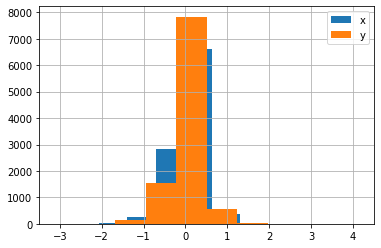

In [32]:
import matplotlib.pyplot as plt
(waypoint_df['x'] - waypoint_df['_x']).hist(label='x')
(waypoint_df['y'] - waypoint_df['_y']).hist(label='y')
plt.legend()

In [33]:
sub = sub.merge(waypoint_df[['site_path_timestamp', '_x', '_y']], on='site_path_timestamp').set_index('site_path_timestamp')
sub = sub.drop(['x','y'], axis=1).rename(columns={'_x':'x', '_y':'y'})
sub

,floor,x,y
site_path_timestamp,,,
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000000009,0,90.654732,97.780129
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000009017,0,83.571348,100.234323
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000015326,0,85.260265,104.439258
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000018763,0,85.999588,106.545549
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000022328,0,85.812106,109.608126
...,...,...,...
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_0000000082589,5,210.476250,97.851999
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_0000000085758,5,208.640320,100.710854
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_0000000090895,5,204.606167,106.763762


In [34]:
sub.to_csv(EXP_NAME + '_sub.csv')

## 後処理

## cost minimaization

In [35]:
import multiprocessing
import scipy.interpolate
import scipy.sparse
from tqdm import tqdm
import sys
sys.path.append('../../')
from src.io_f import read_data_file
from src import compute_f

In [36]:
def compute_rel_positions(acce_datas, ahrs_datas):
    step_timestamps, step_indexs, step_acce_max_mins = compute_f.compute_steps(acce_datas)
    headings = compute_f.compute_headings(ahrs_datas)
    stride_lengths = compute_f.compute_stride_length(step_acce_max_mins)
    step_headings = compute_f.compute_step_heading(step_timestamps, headings)
    rel_positions = compute_f.compute_rel_positions(stride_lengths, step_headings)
    return rel_positions
    
def correct_path(args):
    path, path_df = args
    
    T_ref  = path_df['timestamp'].values
    xy_hat = path_df[['x', 'y']].values
    
    example = read_data_file(f'{root_dir}/indoor-location-navigation/test/{path}.txt')
    rel_positions = compute_rel_positions(example.acce, example.ahrs)
    if T_ref[-1] > rel_positions[-1, 0]:
        rel_positions = [np.array([[0, 0, 0]]), rel_positions, np.array([[T_ref[-1], 0, 0]])]
    else:
        rel_positions = [np.array([[0, 0, 0]]), rel_positions]
    rel_positions = np.concatenate(rel_positions)
    
    T_rel = rel_positions[:, 0]
    delta_xy_hat = np.diff(scipy.interpolate.interp1d(T_rel, np.cumsum(rel_positions[:, 1:3], axis=0), axis=0)(T_ref), axis=0)

    N = xy_hat.shape[0]
    delta_t = np.diff(T_ref)
    alpha = (8.1)**(-2) * np.ones(N)
    beta  = (0.3 + 0.3 * 1e-3 * delta_t)**(-2)
    A = scipy.sparse.spdiags(alpha, [0], N, N)
    B = scipy.sparse.spdiags( beta, [0], N-1, N-1)
    D = scipy.sparse.spdiags(np.stack([-np.ones(N), np.ones(N)]), [0, 1], N-1, N)

    Q = A + (D.T @ B @ D)
    c = (A @ xy_hat) + (D.T @ (B @ delta_xy_hat))
    xy_star = scipy.sparse.linalg.spsolve(Q, c)

    return pd.DataFrame({
        'site_path_timestamp' : path_df['site_path_timestamp'],
        'floor' : path_df['floor'],
        'x' : xy_star[:, 0],
        'y' : xy_star[:, 1],
    })

def correct_path_train(args):
    #print(args)
    (site_id, path, floor), path_df = args
    
    T_ref  = path_df['timestamp'].values
    xy_hat = path_df[['x', 'y']].values
    
    example = read_data_file(f'{root_dir}/indoor-location-navigation/train/{site_id}/{floor}/{path}.txt')
    rel_positions = compute_rel_positions(example.acce, example.ahrs)
    if T_ref[-1] > rel_positions[-1, 0]:
        rel_positions = [np.array([[0, 0, 0]]), rel_positions, np.array([[T_ref[-1], 0, 0]])]
    else:
        rel_positions = [np.array([[0, 0, 0]]), rel_positions]
    rel_positions = np.concatenate(rel_positions)
    
    T_rel = rel_positions[:, 0]

    try:
        delta_xy_hat = np.diff(scipy.interpolate.interp1d(T_rel, np.cumsum(rel_positions[:, 1:3], axis=0), axis=0)(T_ref), axis=0)
    except:
        return pd.DataFrame({
            'site_path_timestamp' : path_df['site_path_timestamp'],
            'floor' : path_df['floor'],
            'x' : path_df['x'].to_numpy(),
            'y' : path_df['y'].to_numpy()
        })
    

    N = xy_hat.shape[0]
    delta_t = np.diff(T_ref)
    alpha = (8.1)**(-2) * np.ones(N)
    beta  = (0.3 + 0.3 * 1e-3 * delta_t)**(-2)
    A = scipy.sparse.spdiags(alpha, [0], N, N)
    B = scipy.sparse.spdiags( beta, [0], N-1, N-1)
    D = scipy.sparse.spdiags(np.stack([-np.ones(N), np.ones(N)]), [0, 1], N-1, N)

    Q = A + (D.T @ B @ D)
    c = (A @ xy_hat) + (D.T @ (B @ delta_xy_hat))
    xy_star = scipy.sparse.linalg.spsolve(Q, c)


    return pd.DataFrame({
        'site_path_timestamp' : path_df['site_path_timestamp'],
        'floor' : path_df['floor'],
        'x' : xy_star[:, 0],
        'y' : xy_star[:, 1],
    })

In [37]:
%%time

oofs_df = oofs_df.rename(columns={'x':'target_x', 'y':'target_y', 'oof_x':'x', 'oof_y':'y'})
processes = multiprocessing.cpu_count()
with multiprocessing.Pool(processes=processes) as pool:
    dfs = pool.imap_unordered(correct_path_train, oofs_df.groupby(['site_id_str', 'path', 'floor_str']))
    dfs = tqdm(dfs)
    dfs = list(dfs)

oof_post_process = pd.concat(dfs).sort_index()
oofs_df['oof_min_x'] = oof_post_process['x']
oofs_df['oof_min_y'] = oof_post_process['y']

# 元に戻す
oofs_df = oofs_df.rename(columns={'x':'oof_x', 'y':'oof_y'})
oofs_df

10852it [03:37, 49.91it/s]


CPU times: user 40.4 s, sys: 7.4 s, total: 47.8 s
Wall time: 3min 39s


,timestamp,target_x,target_y,site_id,site_id_str,wifi_x,wifi_y,floor,floor_str,path,time_diff,oof_x,oof_y,oof_floor,site_path_timestamp,oof_min_x,oof_min_y
0,1561368762838,78.21819,38.999737,0,5a0546857ecc773753327266,77.890465,37.584921,2,F3,5d10a1669c50c70008fe8977,1969,83.060036,39.327400,0.208115,5a0546857ecc773753327266_5d10a1669c50c70008fe8...,84.192015,36.041013
1,1561368762838,78.21819,38.999737,0,5a0546857ecc773753327266,77.562740,36.170105,2,F3,5d10a1669c50c70008fe8977,3966,87.609009,32.948154,0.207081,5a0546857ecc773753327266_5d10a1669c50c70008fe8...,84.193568,36.036505
2,1561368774057,76.25184,30.510840,0,5a0546857ecc773753327266,77.235015,34.755289,2,F3,5d10a1669c50c70008fe8977,-5250,80.982658,30.002529,0.210902,5a0546857ecc773753327266_5d10a1669c50c70008fe8...,83.877359,27.774754
3,1561368774057,76.25184,30.510840,0,5a0546857ecc773753327266,77.202679,21.519628,2,F3,5d10a1669c50c70008fe8977,8838,85.754807,28.957649,0.205257,5a0546857ecc773753327266_5d10a1669c50c70008fe8...,83.878198,27.771426
4,1561368774057,76.25184,30.510840,0,5a0546857ecc773753327266,76.991381,23.517675,2,F3,5d10a1669c50c70008fe8977,6812,80.875351,21.473248,0.211020,5a0546857ecc773753327266_5d10a1669c50c70008fe8...,83.876462,27.766471
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258120,1574420742502,193.20488,108.001520,23,5dc8cea7659e181adb076a3f,197.825134,107.932187,-1,B1,5dd7c119c5b77e0006b16b99,4790,199.718857,104.165504,0.000000,5dc8cea7659e181adb076a3f_5dd7c119c5b77e0006b16...,199.883629,103.697072
258121,1574420742502,193.20488,108.001520,23,5dc8cea7659e181adb076a3f,194.128931,107.987653,-1,B1,5dd7c119c5b77e0006b16b99,1006,200.871445,103.987137,0.000000,5dc8cea7659e181adb076a3f_5dd7c119c5b77e0006b16...,199.864212,103.691962
258122,1574420753754,204.29349,107.835120,23,5dc8cea7659e181adb076a3f,199.673236,107.904453,-1,B1,5dd7c119c5b77e0006b16b99,-4550,200.354507,102.642044,0.000000,5dc8cea7659e181adb076a3f_5dd7c119c5b77e0006b16...,206.808214,104.526523
258123,1574420753754,204.29349,107.835120,23,5dc8cea7659e181adb076a3f,201.521337,107.876720,-1,B1,5dd7c119c5b77e0006b16b99,-2662,201.424820,104.923492,0.000000,5dc8cea7659e181adb076a3f_5dd7c119c5b77e0006b16...,206.796269,104.523594


In [38]:
# waypoint補正前のx,yでの評価
oof_score_post_process = mean_position_error(
    oofs_df['oof_min_x'], oofs_df['oof_min_y'], 0, 
    oofs_df['target_x'], oofs_df['target_y'], 0
    )
print(f"(after cost-min) CV:{oof_score_post_process}")

(after cost-min) CV:6.383151060723588


In [39]:
# waypoint補正後のx,yでの評価
oof_score_post_process = mean_position_error(
    oofs_df['oof_min_x'], oofs_df['oof_min_y'], 0, 
    oofs_df['wifi_x'], oofs_df['wifi_y'], 0
    )
print(f"(after cost-min) CV:{oof_score_post_process}")

(after cost-min) CV:6.54062651005452


In [40]:
# x_pred = oofs_df["oof_min_x"]
# y_pred = oofs_df["oof_min_y"]
# f_pred = oofs_df["floor"]  # 正解を与える
# x_true = oofs_df["wifi_x"]
# y_true = oofs_df["wifi_y"]
# f_true = oofs_df["floor"]
# site_arr = oofs_df["site_id_str"]
# df_result_site2 = calc_metrics_site(x_pred, y_pred, f_pred, x_true, y_true, f_true, site_arr)
# df_result_site2.style.bar(subset=['n_sample', 'score'], color=['teal'])

In [41]:
# site_eval_report(df_result_site2)

In [42]:
sub = sub.reset_index()
sub_org = sub.copy()
tmp = sub['site_path_timestamp'].apply(lambda s : pd.Series(s.split('_')))
sub['site'] = tmp[0]
sub['path'] = tmp[1]
sub['timestamp'] = tmp[2].astype(float)
sub

,site_path_timestamp,floor,x,y,site,path,timestamp
0,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,90.654732,97.780129,5a0546857ecc773753327266,046cfa46be49fc10834815c6,9.0
1,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,83.571348,100.234323,5a0546857ecc773753327266,046cfa46be49fc10834815c6,9017.0
2,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,85.260265,104.439258,5a0546857ecc773753327266,046cfa46be49fc10834815c6,15326.0
3,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,85.999588,106.545549,5a0546857ecc773753327266,046cfa46be49fc10834815c6,18763.0
4,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,85.812106,109.608126,5a0546857ecc773753327266,046cfa46be49fc10834815c6,22328.0
...,...,...,...,...,...,...,...
10128,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,210.476250,97.851999,5dc8cea7659e181adb076a3f,fd64de8c4a2fc5ebb0e9f412,82589.0
10129,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,208.640320,100.710854,5dc8cea7659e181adb076a3f,fd64de8c4a2fc5ebb0e9f412,85758.0
10130,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,204.606167,106.763762,5dc8cea7659e181adb076a3f,fd64de8c4a2fc5ebb0e9f412,90895.0
10131,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,198.877228,113.097631,5dc8cea7659e181adb076a3f,fd64de8c4a2fc5ebb0e9f412,96899.0


In [43]:
processes = multiprocessing.cpu_count()
with multiprocessing.Pool(processes=processes) as pool:
    dfs = pool.imap_unordered(correct_path, sub.groupby(['path']))
    dfs = tqdm(dfs)
    dfs = list(dfs)
new_sub = pd.concat(dfs).sort_values('site_path_timestamp')
new_sub

626it [00:33, 18.75it/s]


,site_path_timestamp,floor,x,y
0,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,91.836090,94.595703
1,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,82.075074,98.590058
2,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,84.160473,103.981244
3,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,85.441651,107.880513
4,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,85.921447,111.583555
...,...,...,...,...
10128,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,209.231012,99.864709
10129,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,207.323111,103.518196
10130,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,203.027197,110.479597
10131,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,195.153532,116.047997


In [44]:
new_sub.to_csv(RUN_NAME + '_cost_sub.csv', index=False)

## snap to grid

In [45]:
from scipy.spatial.distance import cdist
def sub_process(sub, train_waypoints):
    train_waypoints['isTrainWaypoint'] = True
    sub = split_col(sub[['site_path_timestamp','floor','x','y']]).copy()
    sub = sub.merge(train_waypoints[['site','floorNo','floor']].drop_duplicates(), how='left')
    sub = sub.merge(
        train_waypoints[['x','y','site','floor','isTrainWaypoint']].drop_duplicates(),
        how='left',
        on=['site','x','y','floor']
             )
    sub['isTrainWaypoint'] = sub['isTrainWaypoint'].fillna(False)
    return sub.copy()

def split_col(df):
    df = pd.concat([
        df['site_path_timestamp'].str.split('_', expand=True) \
        .rename(columns={0:'site',
                         1:'path',
                         2:'timestamp'}),
        df
    ], axis=1).copy()
    return df

floor_map = {"B2":-2, "B1":-1, "F1":0, "F2": 1, "F3":2,
             "F4":3, "F5":4, "F6":5, "F7":6,"F8":7,"F9":8,
             "1F":0, "2F":1, "3F":2, "4F":3, "5F":4, "6F":5,
             "7F":6, "8F": 7, "9F":8}

def add_xy(df):
    df['xy'] = [(x, y) for x,y in zip(df['x'], df['y'])]
    return df

def closest_point(point, points):
    """ Find closest point from a list of points. """
    return points[cdist([point], points).argmin()]

def snap_to_grid(sub, threshold):
    """
    Snap to grid if within a threshold.
    
    x, y are the predicted points.
    x_, y_ are the closest grid points.
    _x_, _y_ are the new predictions after post processing.
    """
    sub['_x_'] = sub['x']
    sub['_y_'] = sub['y']
    sub.loc[sub['dist'] < threshold, '_x_'] = sub.loc[sub['dist'] < threshold]['x_']
    sub.loc[sub['dist'] < threshold, '_y_'] = sub.loc[sub['dist'] < threshold]['y_']
    return sub.copy()


In [50]:
# train_waypoints = pd.read_csv('../../input/indoor-location-train-waypoints/train_waypoints.csv')
# 線形補完しているwaypointをtrain_waypoints（grid）とする。gridを増やすのが狙い。
train_waypoints = oofs_df[['oof_x', 'oof_y', 'timestamp', 'site_id_str', 'floor', 'floor_str', 'path']]
train_waypoints = train_waypoints.rename(columns={'oof_x':'x', 'oof_y':"y", 'site_id_str':"site", 'floor_str':'floorNo'})

snap_df = oofs_df[['site_path_timestamp','floor','oof_min_x','oof_min_y']].copy()
snap_df = snap_df.rename(columns={'oof_min_x':'x', 'oof_min_y':'y'})
snap_df = sub_process(snap_df, train_waypoints)
snap_df = add_xy(snap_df)
train_waypoints = add_xy(train_waypoints)

ds = []
for (site, myfloor), d in tqdm(snap_df.groupby(['site','floor'])):
    true_floor_locs = train_waypoints.loc[(train_waypoints['floor'] == myfloor) &
                                          (train_waypoints['site'] == site)] \
        .reset_index(drop=True)
    if len(true_floor_locs) == 0:
        print(f'Skipping {site} {myfloor}')
        continue
    d['matched_point'] = [closest_point(x, list(true_floor_locs['xy'])) for x in d['xy']]
    d['oof_min_snap_x'] = d['matched_point'].apply(lambda x: x[0])
    d['oof_min_snap_y'] = d['matched_point'].apply(lambda x: x[1])
    ds.append(d)

# 上書き
snap_df = pd.concat(ds).sort_index()
snap_df

100%|██████████| 139/139 [05:50<00:00,  2.52s/it]


,site,path,timestamp,site_path_timestamp,floor,x,y,floorNo,isTrainWaypoint,xy,matched_point,oof_min_snap_x,oof_min_snap_y
0,5a0546857ecc773753327266,5d10a1669c50c70008fe8977,1561368762838,5a0546857ecc773753327266_5d10a1669c50c70008fe8...,2,84.192015,36.041013,F3,False,"(84.19201520078279, 36.04101271048404)","(84.51937866210938, 36.82925796508789)",84.519379,36.829258
1,5a0546857ecc773753327266,5d10a1669c50c70008fe8977,1561368762838,5a0546857ecc773753327266_5d10a1669c50c70008fe8...,2,84.193568,36.036505,F3,False,"(84.19356798472684, 36.03650463435642)","(84.51937866210938, 36.82925796508789)",84.519379,36.829258
2,5a0546857ecc773753327266,5d10a1669c50c70008fe8977,1561368774057,5a0546857ecc773753327266_5d10a1669c50c70008fe8...,2,83.877359,27.774754,F3,False,"(83.87735947288672, 27.774753540492046)","(84.60396575927734, 27.170074462890625)",84.603966,27.170074
3,5a0546857ecc773753327266,5d10a1669c50c70008fe8977,1561368774057,5a0546857ecc773753327266_5d10a1669c50c70008fe8...,2,83.878198,27.771426,F3,False,"(83.87819793623039, 27.771425950758246)","(84.60396575927734, 27.170074462890625)",84.603966,27.170074
4,5a0546857ecc773753327266,5d10a1669c50c70008fe8977,1561368774057,5a0546857ecc773753327266_5d10a1669c50c70008fe8...,2,83.876462,27.766471,F3,False,"(83.87646217655305, 27.766471168596194)","(84.60396575927734, 27.170074462890625)",84.603966,27.170074
...,...,...,...,...,...,...,...,...,...,...,...,...,...
258120,5dc8cea7659e181adb076a3f,5dd7c119c5b77e0006b16b99,1574420742502,5dc8cea7659e181adb076a3f_5dd7c119c5b77e0006b16...,-1,199.883629,103.697072,B1,False,"(199.88362857032826, 103.69707151719705)","(199.71885681152344, 104.1655044555664)",199.718857,104.165504
258121,5dc8cea7659e181adb076a3f,5dd7c119c5b77e0006b16b99,1574420742502,5dc8cea7659e181adb076a3f_5dd7c119c5b77e0006b16...,-1,199.864212,103.691962,B1,False,"(199.86421238553834, 103.691962298065)","(199.71885681152344, 104.1655044555664)",199.718857,104.165504
258122,5dc8cea7659e181adb076a3f,5dd7c119c5b77e0006b16b99,1574420753754,5dc8cea7659e181adb076a3f_5dd7c119c5b77e0006b16...,-1,206.808214,104.526523,B1,False,"(206.808213571618, 104.52652302830111)","(206.0470428466797, 105.47453308105469)",206.047043,105.474533
258123,5dc8cea7659e181adb076a3f,5dd7c119c5b77e0006b16b99,1574420753754,5dc8cea7659e181adb076a3f_5dd7c119c5b77e0006b16...,-1,206.796269,104.523594,B1,False,"(206.79626854431598, 104.52359392496899)","(206.0470428466797, 105.47453308105469)",206.047043,105.474533


In [51]:
oofs_df['oof_min_snap_x'] = snap_df['oof_min_snap_x']
oofs_df['oof_min_snap_y'] = snap_df['oof_min_snap_y']
oofs_df

,timestamp,target_x,target_y,site_id,site_id_str,wifi_x,wifi_y,floor,floor_str,path,time_diff,oof_x,oof_y,oof_floor,site_path_timestamp,oof_min_x,oof_min_y,oof_min_snap_x,oof_min_snap_y
0,1561368762838,78.21819,38.999737,0,5a0546857ecc773753327266,77.890465,37.584921,2,F3,5d10a1669c50c70008fe8977,1969,83.060036,39.327400,0.208115,5a0546857ecc773753327266_5d10a1669c50c70008fe8...,84.192015,36.041013,84.519379,36.829258
1,1561368762838,78.21819,38.999737,0,5a0546857ecc773753327266,77.562740,36.170105,2,F3,5d10a1669c50c70008fe8977,3966,87.609009,32.948154,0.207081,5a0546857ecc773753327266_5d10a1669c50c70008fe8...,84.193568,36.036505,84.519379,36.829258
2,1561368774057,76.25184,30.510840,0,5a0546857ecc773753327266,77.235015,34.755289,2,F3,5d10a1669c50c70008fe8977,-5250,80.982658,30.002529,0.210902,5a0546857ecc773753327266_5d10a1669c50c70008fe8...,83.877359,27.774754,84.603966,27.170074
3,1561368774057,76.25184,30.510840,0,5a0546857ecc773753327266,77.202679,21.519628,2,F3,5d10a1669c50c70008fe8977,8838,85.754807,28.957649,0.205257,5a0546857ecc773753327266_5d10a1669c50c70008fe8...,83.878198,27.771426,84.603966,27.170074
4,1561368774057,76.25184,30.510840,0,5a0546857ecc773753327266,76.991381,23.517675,2,F3,5d10a1669c50c70008fe8977,6812,80.875351,21.473248,0.211020,5a0546857ecc773753327266_5d10a1669c50c70008fe8...,83.876462,27.766471,84.603966,27.170074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258120,1574420742502,193.20488,108.001520,23,5dc8cea7659e181adb076a3f,197.825134,107.932187,-1,B1,5dd7c119c5b77e0006b16b99,4790,199.718857,104.165504,0.000000,5dc8cea7659e181adb076a3f_5dd7c119c5b77e0006b16...,199.883629,103.697072,199.718857,104.165504
258121,1574420742502,193.20488,108.001520,23,5dc8cea7659e181adb076a3f,194.128931,107.987653,-1,B1,5dd7c119c5b77e0006b16b99,1006,200.871445,103.987137,0.000000,5dc8cea7659e181adb076a3f_5dd7c119c5b77e0006b16...,199.864212,103.691962,199.718857,104.165504
258122,1574420753754,204.29349,107.835120,23,5dc8cea7659e181adb076a3f,199.673236,107.904453,-1,B1,5dd7c119c5b77e0006b16b99,-4550,200.354507,102.642044,0.000000,5dc8cea7659e181adb076a3f_5dd7c119c5b77e0006b16...,206.808214,104.526523,206.047043,105.474533
258123,1574420753754,204.29349,107.835120,23,5dc8cea7659e181adb076a3f,201.521337,107.876720,-1,B1,5dd7c119c5b77e0006b16b99,-2662,201.424820,104.923492,0.000000,5dc8cea7659e181adb076a3f_5dd7c119c5b77e0006b16...,206.796269,104.523594,206.047043,105.474533


In [52]:
# waypoint補正前のx,yでの評価
oof_score_post_process = mean_position_error(
    oofs_df['oof_min_snap_x'], oofs_df['oof_min_snap_y'], 0, 
    oofs_df['target_x'], oofs_df['target_y'], 0
    )
print(f"(after cost-min + snap) CV:{oof_score_post_process}")

(after cost-min + snap) CV:6.439693375609553


In [53]:
# waypoint補正前のx,yでの評価
oof_score_post_process = mean_position_error(
    oofs_df['oof_min_snap_x'], oofs_df['oof_min_snap_y'], 0, 
    oofs_df['wifi_x'], oofs_df['wifi_y'], 0
    )
print(f"(after cost-min + snap) CV:{oof_score_post_process}")

(after cost-min + snap) CV:6.554692961763338


In [59]:
# x_pred = oofs_df["oof_min_snap_x"]
# y_pred = oofs_df["oof_min_snap_y"]
# f_pred = oofs_df["floor"]  # 正解を与える
# x_true = oofs_df["wifi_x"]
# y_true = oofs_df["wifi_y"]
# f_true = oofs_df["floor"]
# site_arr = oofs_df["site_id_str"]
# df_result_site3 = calc_metrics_site(x_pred, y_pred, f_pred, x_true, y_true, f_true, site_arr)
# df_result_site3.style.bar(subset=['n_sample', 'score'], color=['teal'])

In [60]:
# site_eval_report(df_result_site3)

In [61]:
# train_waypoints = pd.read_csv('../../input/indoor-location-train-waypoints/train_waypoints.csv')

new_sub = sub_process(new_sub, train_waypoints)
new_sub = add_xy(new_sub)
train_waypoints = add_xy(train_waypoints)

ds = []
for (site, myfloor), d in new_sub.groupby(['site','floor']):
    true_floor_locs = train_waypoints.loc[(train_waypoints['floor'] == myfloor) &
                                          (train_waypoints['site'] == site)] \
        .reset_index(drop=True)
    if len(true_floor_locs) == 0:
        print(f'Skipping {site} {myfloor}')
        continue
    d['matched_point'] = [closest_point(x, list(true_floor_locs['xy'])) for x in d['xy']]
    d['x_'] = d['matched_point'].apply(lambda x: x[0])
    d['y_'] = d['matched_point'].apply(lambda x: x[1])
    ds.append(d)

new_sub2 = pd.concat(ds)

In [63]:
new_sub2 = new_sub2[['site_path_timestamp','floor','x_','y_']].sort_index()
new_sub2 = new_sub2.rename(columns={'x_':'x', 'y_':'y'})
new_sub2

,site_path_timestamp,floor,x,y
0,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,93.728470,97.94886
1,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,85.360190,99.07578
2,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,87.162830,104.45055
3,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,88.779945,108.93324
4,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,89.695300,111.91780
...,...,...,...,...
10128,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,206.627910,102.63521
10129,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,206.627910,102.63521
10130,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,206.334900,111.25086
10131,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,195.733580,120.70842


In [64]:
new_sub2.to_csv(RUN_NAME + '_cost_snap_sub.csv', index=False)

In [ ]:
# import matplotlib.pyplot as plt
# df_result_site1['score'].plot(label='oof')
# df_result_site2['score'].plot(label='cost')
# df_result_site3['score'].plot(label='cost+snap')
# plt.legend()
# plt.grid()
# plt.savefig('site_result.png')